# Experiment Initialization

Here, the terms of the experiment are defined, such as the location of the files in S3 (bucket and folder name), and each of the video prefixes (everything before the file extension) that need to be tracked. 

Note that these videos should be similar-ish: while we can account for differences in mean intensities between videos, particle sizes should be approximately the same, and (slightly less important) particles should be moving at about the same order of magnitude speed. In this experiment, these videos were taken in 0.4% agarose gel at 100x magnification and 100.02 fps shutter speeds with nanoparticles of about 100nm in diameter.

In [1]:
to_track = [] # This is going to be the list of all filenames that will be included in the analysis
start_knot = 25 #Must be unique number for every run on Cloudknot.

remote_folder = '1_6_19_P01_MPT_in_PNNs' # The folder in AWS S3 containing the files to be analyzed
bucket = 'mckenna.data' # The bucket in AWS S3 where the remote_folder is contained
vids = 5 # this is the number of vids that were taken per condition (usually corresponding to different locations)
visc = ['LPS_ipsi_PNN', 'LPS_contra_PNN','PAM_ipsi','PAM_contra']
for vis in visc:
    for num in range(1, vids+1):
        to_track.append('{}_vid_{}'.format(vis, num))

In [2]:
to_track

['LPS_ipsi_PNN_vid_1',
 'LPS_ipsi_PNN_vid_2',
 'LPS_ipsi_PNN_vid_3',
 'LPS_ipsi_PNN_vid_4',
 'LPS_ipsi_PNN_vid_5',
 'LPS_contra_PNN_vid_1',
 'LPS_contra_PNN_vid_2',
 'LPS_contra_PNN_vid_3',
 'LPS_contra_PNN_vid_4',
 'LPS_contra_PNN_vid_5',
 'PAM_ipsi_vid_1',
 'PAM_ipsi_vid_2',
 'PAM_ipsi_vid_3',
 'PAM_ipsi_vid_4',
 'PAM_ipsi_vid_5',
 'PAM_contra_vid_1',
 'PAM_contra_vid_2',
 'PAM_contra_vid_3',
 'PAM_contra_vid_4',
 'PAM_contra_vid_5']

The videos used with this analysis are fairly large (2048 x 2048 pixels and 651 frames), and in cases like this, the tracking algorithm can quickly eat up RAM. In this case, we chose to crop the videos to 512 x 512 images such that we can run our jobs on smaller EC2 instances with 16GB of RAM. 

Note that larger jobs can be made with user-defined functions such that splitting isn't necessary-- or perhaps an intermediate amount of memory that contains splitting, tracking, and msd calculation functions all performed on a single EC2 instance.

The compiled functions in the knotlets module require access to buckets on AWS. In this case, we will be using a publicly (read-only) bucket. If users want to run this notebook on their own, will have to transfer files from nancelab.publicfiles to their own bucket, as it requires writing to S3 buckets.

In [2]:
import diff_classifier.knotlets as kn

In [ ]:
# This cell uses the function kn.split() to split all of the videos contained in 'to_track' into 16 smaller videos on which the actual tracking will be performed
for prefix in to_track:
    kn.split(prefix, remote_folder=remote_folder, bucket=bucket)

## Tracking predictor

Tracking normally requires user input in the form of tracking parameters e.g. particle radius, linking max distance, max frame gap etc. When large datasets aren't required, each video can be manageably manually tracked using the TrackMate GUI. However, when datasets get large e.g. >20 videos, this can become extremely arduous. For videos that are fairly similar, you can get away with using similar tracking parameters across all videos. However, one parameter that is a little more noisy that the others is the quality filter value. Quality is a numerical value that approximate how likely a particle is to be "real." 

In this case, I built a predictor that estimates the quality filter value based on intensity distributions from the input images. Using a relatively small training dataset (5-20 videos), users can get fairly good estimates of quality filter values that can be used in parallelized tracking workflows.

Note: in the current setup, the predictor should be run in Python 3. While the code will run in Python 3, there are differences between the random number generators in Python2 and Python3 that I was not able to control for.

In [1]:
import os
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import diff_classifier.knotlets as kn
import numpy as np
from sklearn.externals import joblib

The regress_sys function should be run twice. When have_output is set to False, it generates a list of files that the user should manually track using Trackmate. Once the quality filter values are found, they can be used as input (y) to generate a regress object that can predict quality filter values for additional videos. Once y is assigned, set have_output to True and re-run the cell.

In [ ]:
tnum=15 #number of training datasets
pref = []
for num in to_track:                    
    for row in range(0, 4):
        for col in range(0, 4):
            pref.append("{}_{}_{}".format(num, row, col))

y = np.array([2.96, 2.74, 2.89, 2.82, 2.97, 2.96, 5.10, 2.44, 2.60, 4.01, 4.59, 2.71, 1.15, 2.25, 3.92])

# Creates regression object based of training dataset composed of input images and manually
# calculated quality cutoffs from tracking with GUI interface.
regress = ij.regress_sys(remote_folder, pref, y, tnum, randselect=True,
                         have_output=True, bucket_name=bucket)
#Read up on how regress_sys works before running.

In [ ]:
#Pickle object
filename = 'regress.obj'
with open(filename,'wb') as fp:
    joblib.dump(regress,fp)

import boto3
s3 = boto3.client('s3')
aws.upload_s3(filename, remote_folder+'/'+filename, bucket_name=bucket)

Users should input all tracking parameters into the tparams object. Note that the quality value will be overwritten by values found using the quality predictor found above. Never change threshold, median intensity, or snr

In [5]:
tparams1 = {'radius': 7.0, 'threshold': 0.0, 'do_median_filtering': False,
           'quality': 10.0, 'xdims': (0, 511), 'ydims': (1, 511),
           'median_intensity': 300.0, 'snr': 0.0, 'linking_max_distance': 15.0,
           'gap_closing_max_distance': 20.0, 'max_frame_gap': 10,
           'track_duration': 21.6}

tparams2 = {'radius': 7.0, 'threshold': 0.0, 'do_median_filtering': False,
           'quality': 10.0, 'xdims': (0, 511), 'ydims': (1, 511),
           'median_intensity': 300.0, 'snr': 0.0, 'linking_max_distance': 15.0,
           'gap_closing_max_distance': 20.0, 'max_frame_gap': 10,
           'track_duration': 21.6}

## Cloudknot setup

Cloudknot requires the user to define a function that will be sent to multiple computers to run. In this case, the function knotlets.tracking will be used. We create a docker image that has the required installations (defined by the requirements.txt file from diff_classifier on Github, and the base Docker Image below that has Fiji pre-installed in the correct location.

Note that I modify the Docker image below such that the correct version of boto3 is installed. For some reason, versions later than 1.5.28 error out, so I specified 5.28 as the correct version. Run my_image.build below to double-check that the Docker image is successfully built prior to submitting the job to Cloudknot.

** Before you run this next cell, you have to switch the kernel from Python 3 to Python 2, by doing the following: **
 1. Kernel -> Restart and clear output
 2. Kernel -> Change Kernel -> Python 2
 3. Rerun cells required to run below cell
 
 ** One other important thing to note: 
 - If you are performing the tracking, be sure that the my_image =  line is set to ck.DockerImage(func=kn.tracking,...
 - If you are performing the MSD/feature calculation (after you've carried out the tracking), be sure that the my_image = line is se to ck.DockerImage(func=kn.assemble_msds, ...
 
 Everything else should stay the same

In [6]:
import cloudknot as ck
import os.path as op

github_installs=('https://github.com/ccurtis7/diff_classifier.git')
#my_image = ck.DockerImage(func=kn.tracking, base_image='arokem/python3-fiji:0.3', github_installs=github_installs)
my_image = ck.DockerImage(func=kn.assemble_msds, base_image='arokem/python3-fiji:0.3', github_installs=github_installs)
docker_file = open(my_image.docker_path)
docker_string = docker_file.read()
docker_file.close()

req = open(op.join(op.split(my_image.docker_path)[0], 'requirements.txt'))
req_string = req.read()
req.close()

new_req = req_string[0:req_string.find('\n')-4]+'5.28'+ req_string[req_string.find('\n'):]
req_overwrite = open(op.join(op.split(my_image.docker_path)[0], 'requirements.txt'), 'w')
req_overwrite.write(new_req)
req_overwrite.close()

Following the execution of this cell, you have to check that the requirements.txt file has the first line 'boto3==1.5.28'.
    - This file can be found in source -> diff-classifier -> notebooks -> development -> most recent file

If it doesn't, you may have to change the line in the cell above that says 'new_req = reg_string[0:req_string.find('\n')-4]+'5.28'+ reg_string[reg_string.find('\n'):]'

In [ ]:
my_image.build("HBSS_1", image_name="test_image")

In [7]:
to_track

['LPS_ipsi_PNN_vid_1',
 'LPS_ipsi_PNN_vid_2',
 'LPS_ipsi_PNN_vid_3',
 'LPS_ipsi_PNN_vid_4',
 'LPS_ipsi_PNN_vid_5',
 'LPS_contra_PNN_vid_1',
 'LPS_contra_PNN_vid_2',
 'LPS_contra_PNN_vid_3',
 'LPS_contra_PNN_vid_4',
 'LPS_contra_PNN_vid_5',
 'PAM_ipsi_vid_1',
 'PAM_ipsi_vid_2',
 'PAM_ipsi_vid_3',
 'PAM_ipsi_vid_4',
 'PAM_ipsi_vid_5',
 'PAM_contra_vid_1',
 'PAM_contra_vid_2',
 'PAM_contra_vid_3',
 'PAM_contra_vid_4',
 'PAM_contra_vid_5']

The object all_maps is an iterable containing all the inputs sent to Cloudknot. This is useful, because if the user needs to modify some of the tracking parameters for a single video, this can be done prior to submission to Cloudknot.

In [8]:
names = []
all_maps = []
for prefix in to_track:    
    for i in range(0, 4):
        for j in range(0, 4):
            names.append('{}_{}_{}'.format(prefix, i, j))
            all_maps.append(('{}_{}_{}'.format(prefix, i, j), remote_folder, bucket, 'regress.obj', 4, 4, (512, 512), tparams1))

In [ ]:
start_knot = 21

The Cloudknot knot object sets up the compute environment which will run the code. Note that the name must be unique. Every time you submit a new knot, you should change the name. I do this with the variable start_knot, which I vary for each run.

If larger jobs are anticipated, users can adjust both RAM and storage with the memory and image_id variables. Memory specifies the amount of RAM to be used. Users can build a customized AMI with as much space as they need, and enter the ID into image_ID. Read the Cloudknot documentation for more details.

In [9]:
knot = ck.Knot(name='{}_b{}'.format('mike', start_knot),
               docker_image = my_image,
               memory = 16000,
               resource_type = "SPOT",
               bid_percentage = 100,
               #image_id = 'ami-0e00afdf500081a0d', #May need to change this line
               pars_policies=('AmazonS3FullAccess',))

result_futures = knot.map(all_maps, starmap=True)

In [10]:
knot.clobber()

You can track the progression of your run using the AWS Batch service online -- make sure you are looking at the right US Region.

After the run, you might have some that fail. This usually happens when the computers get claimed by someone paying more money, and your job gets booted from the aws computers. Because of this, you will need to start a knw cloudknot knot and rerun those vids. The set up for that is shown below.

Remember to clobber your knot!

In [ ]:
ck.get_region()

In [ ]:
knot.clobber()

In [11]:
names

['LPS_ipsi_PNN_vid_1_0_0',
 'LPS_ipsi_PNN_vid_1_0_1',
 'LPS_ipsi_PNN_vid_1_0_2',
 'LPS_ipsi_PNN_vid_1_0_3',
 'LPS_ipsi_PNN_vid_1_1_0',
 'LPS_ipsi_PNN_vid_1_1_1',
 'LPS_ipsi_PNN_vid_1_1_2',
 'LPS_ipsi_PNN_vid_1_1_3',
 'LPS_ipsi_PNN_vid_1_2_0',
 'LPS_ipsi_PNN_vid_1_2_1',
 'LPS_ipsi_PNN_vid_1_2_2',
 'LPS_ipsi_PNN_vid_1_2_3',
 'LPS_ipsi_PNN_vid_1_3_0',
 'LPS_ipsi_PNN_vid_1_3_1',
 'LPS_ipsi_PNN_vid_1_3_2',
 'LPS_ipsi_PNN_vid_1_3_3',
 'LPS_ipsi_PNN_vid_2_0_0',
 'LPS_ipsi_PNN_vid_2_0_1',
 'LPS_ipsi_PNN_vid_2_0_2',
 'LPS_ipsi_PNN_vid_2_0_3',
 'LPS_ipsi_PNN_vid_2_1_0',
 'LPS_ipsi_PNN_vid_2_1_1',
 'LPS_ipsi_PNN_vid_2_1_2',
 'LPS_ipsi_PNN_vid_2_1_3',
 'LPS_ipsi_PNN_vid_2_2_0',
 'LPS_ipsi_PNN_vid_2_2_1',
 'LPS_ipsi_PNN_vid_2_2_2',
 'LPS_ipsi_PNN_vid_2_2_3',
 'LPS_ipsi_PNN_vid_2_3_0',
 'LPS_ipsi_PNN_vid_2_3_1',
 'LPS_ipsi_PNN_vid_2_3_2',
 'LPS_ipsi_PNN_vid_2_3_3',
 'LPS_ipsi_PNN_vid_3_0_0',
 'LPS_ipsi_PNN_vid_3_0_1',
 'LPS_ipsi_PNN_vid_3_0_2',
 'LPS_ipsi_PNN_vid_3_0_3',
 'LPS_ipsi_PNN_vid_3_1_0',
 

This creates a new all_maps2 array for any of the videos that failed to get analyzed the first time through. Double check that it worked well by printing the length of it immediately afterwards.

In [19]:
missing = []
all_maps2 = []
import boto3
import botocore

s3 = boto3.resource('s3')


for name in names:
    try:
        s3.Object(bucket, '{}/Traj_{}.csv'.format(remote_folder, name)).load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            missing.append(name)
            all_maps2.append((name, remote_folder, bucket, 'regress.obj',
                             4, 4, (512, 512), tparams1))
        else:
            print('Something else has gone wrong')

In [20]:
len(all_maps2)

0

Make sure you change the name of your knot, either by changing the 'mike1' part or start_knot value.

In [15]:
knot2 = ck.Knot(name='{}_b{}'.format('mike2', start_knot),
               docker_image = my_image,
               memory = 16000,
               resource_type = "SPOT",
               bid_percentage = 100,
               #image_id = 'ami-0e00afdf500081a0d', #May need to change this line
               pars_policies=('AmazonS3FullAccess',))

result_futures2 = knot2.map(all_maps2, starmap=True)

In [ ]:
knot3 = ck.Knot(name='{}_b{}'.format('mike2', start_knot),
               docker_image = my_image,
               memory = 16000,
               resource_type = "SPOT",
               bid_percentage = 100,
               #image_id = 'ami-0e00afdf500081a0d', #May need to change this line
               pars_policies=('AmazonS3FullAccess',))

result_futures3 = knot3.map(all_maps2, starmap=True)

In [17]:
knot2.clobber()

In [21]:
import diff_classifier.aws as aws

In [ ]:
old_folder = 'Gel_Studies/08_14_18_gel_validation/old_msds2'

for name in missing:
    filename = 'Traj_{}.csv'.format(name)
    aws.download_s3('{}/{}'.format(old_folder, filename), filename, bucket_name=bucket)
    aws.upload_s3(filename, '{}/{}'.format(remote_folder, filename), bucket_name=bucket)

In [ ]:
all_maps2 = []
for prefix in to_track:
    all_maps2.append((prefix, remote_folder, bucket, (512, 512), 651, 4, 4))

In [ ]:
all_maps2[0]

Users can monitor the progress of their job in the Batch interface. Once the code is complete, users should clobber their knot to make sure that all AWS resources are removed.

In [ ]:
knot3.clobber()

In [22]:
to_track

['LPS_ipsi_PNN_vid_1',
 'LPS_ipsi_PNN_vid_2',
 'LPS_ipsi_PNN_vid_3',
 'LPS_ipsi_PNN_vid_4',
 'LPS_ipsi_PNN_vid_5',
 'LPS_contra_PNN_vid_1',
 'LPS_contra_PNN_vid_2',
 'LPS_contra_PNN_vid_3',
 'LPS_contra_PNN_vid_4',
 'LPS_contra_PNN_vid_5',
 'PAM_ipsi_vid_1',
 'PAM_ipsi_vid_2',
 'PAM_ipsi_vid_3',
 'PAM_ipsi_vid_4',
 'PAM_ipsi_vid_5',
 'PAM_contra_vid_1',
 'PAM_contra_vid_2',
 'PAM_contra_vid_3',
 'PAM_contra_vid_4',
 'PAM_contra_vid_5']

## Downstream analysis and visualization

The knotlet.assemble_msds function (which can also potentially be submitted to Cloudknot as well for large jobs) calculates the mean squared displacements and trajectory features from the raw trajectory csv files found from the Cloudknot submission. It accesses them from the S3 bucket to which they were saved.

In [23]:
for prefix in to_track:
    kn.assemble_msds(prefix, remote_folder, bucket='mckenna.data')
    print('Successfully output msds for {}'.format(prefix))

Done calculating MSDs for row 0 and col 1
Done calculating MSDs for row 0 and col 2
Done calculating MSDs for row 0 and col 3
Done calculating MSDs for row 1 and col 0
Done calculating MSDs for row 1 and col 1
Done calculating MSDs for row 1 and col 2
Done calculating MSDs for row 1 and col 3
Done calculating MSDs for row 2 and col 0
Done calculating MSDs for row 2 and col 1
Done calculating MSDs for row 2 and col 2
Done calculating MSDs for row 2 and col 3
Done calculating MSDs for row 3 and col 0
Done calculating MSDs for row 3 and col 1
Done calculating MSDs for row 3 and col 2
Done calculating MSDs for row 3 and col 3


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Successfully output msds for LPS_ipsi_PNN_vid_1
Done calculating MSDs for row 0 and col 1
Done calculating MSDs for row 0 and col 2
Done calculating MSDs for row 0 and col 3
Done calculating MSDs for row 1 and col 0
Done calculating MSDs for row 1 and col 1
Done calculating MSDs for row 1 and col 2
Done calculating MSDs for row 1 and col 3
Done calculating MSDs for row 2 and col 0
Done calculating MSDs for row 2 and col 1
Done calculating MSDs for row 2 and col 2
Done calculating MSDs for row 2 and col 3
Done calculating MSDs for row 3 and col 0
Done calculating MSDs for row 3 and col 1
Done calculati

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Successfully output 

Done calculating MSDs for row 3 and col 1
Done calculating MSDs for row 3 and col 2
Done calculating MSDs for row 3 and col 3
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Successfully output msds for PAM_ipsi_vid_4
Done calculating MSDs for row 0 and col 1
Done calculating MSDs for row 0 and col 2
Done calculating MSDs for row 0 and col 3
Done calculating MSDs for row 1 and col 0
Done calculating MSDs for row 1 and col 1
Done calculating MSDs for row 1 and col 2
Done calculating MSDs for row 1 and col 3
Done calculating MSDs for row 2 and col 0
Done calculating MSDs for row 2 and col 1
Done calculating MSDs for row 2 and col 2
Done calculating MSDs for row 2 and col 3
Done calculating MSDs for row 3 and col 0
Done calculating MSDs for row 3 and col 1
Done calculating MSDs for row 3 and col

In [ ]:
for prefix in to_track[5:7]:
    kn.assemble_msds(prefix, remote_folder, bucket='ccurtis.data')
    print('Successfully output msds for {}'.format(prefix))

In [ ]:
all_maps2 = []
for prefix in to_track:    
    all_maps2.append((prefix, remote_folder, bucket, 'regress100.obj',
                     4, 4, (512, 512), tparams))

In [ ]:
knot = ck.Knot(name='download_and_track_{}_b{}'.format('chad', start_knot),
               docker_image = my_image,
               memory = 16000,
               resource_type = "SPOT",
               bid_percentage = 100,
               #image_id = 'ami-0e00afdf500081a0d', #May need to change this line
               pars_policies=('AmazonS3FullAccess',))

Diff_classifier includes some useful imaging tools as well, including checking trajectories, plotting heatmaps of trajectory features, distributions of diffusion coefficients, and MSD plots.

In [2]:
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws

In [25]:
to_track

['LPS_ipsi_PNN_vid_1',
 'LPS_ipsi_PNN_vid_2',
 'LPS_ipsi_PNN_vid_3',
 'LPS_ipsi_PNN_vid_4',
 'LPS_ipsi_PNN_vid_5',
 'LPS_contra_PNN_vid_1',
 'LPS_contra_PNN_vid_2',
 'LPS_contra_PNN_vid_3',
 'LPS_contra_PNN_vid_4',
 'LPS_contra_PNN_vid_5',
 'PAM_ipsi_vid_1',
 'PAM_ipsi_vid_2',
 'PAM_ipsi_vid_3',
 'PAM_ipsi_vid_4',
 'PAM_ipsi_vid_5',
 'PAM_contra_vid_1',
 'PAM_contra_vid_2',
 'PAM_contra_vid_3',
 'PAM_contra_vid_4',
 'PAM_contra_vid_5']

In [26]:
prefix = to_track[0]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted LPS_ipsi_PNN_vid_1 trajectories successfully.


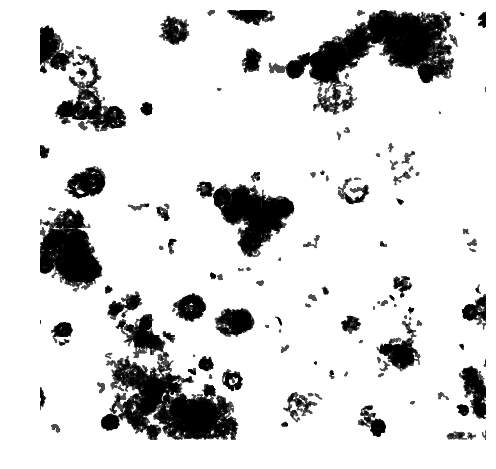

In [27]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

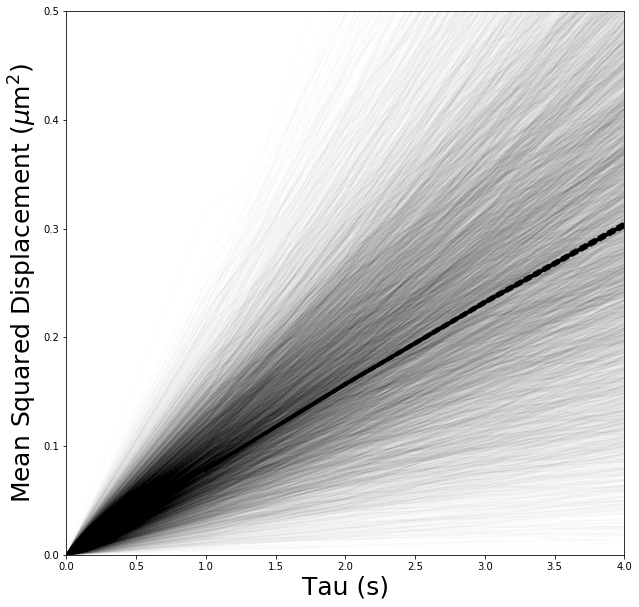

In [28]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [ ]:
hm.plot_heatmap(prefix, upload=False)

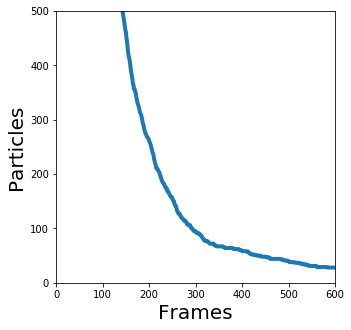

In [30]:
hm.plot_particles_in_frame(prefix, y_range=500, upload=False)

In [31]:
prefix = to_track[1]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted LPS_ipsi_PNN_vid_2 trajectories successfully.


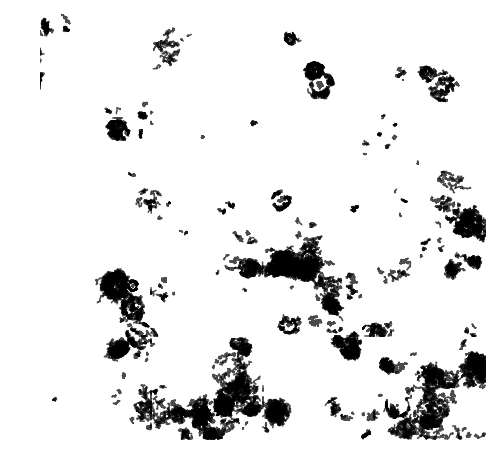

In [32]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

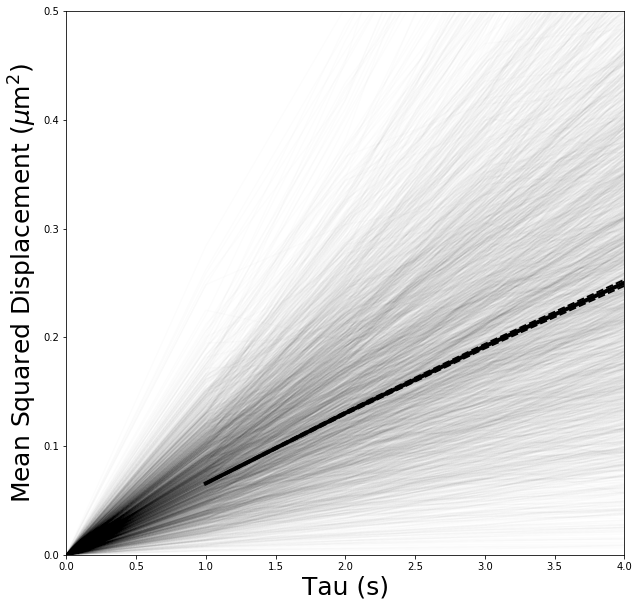

In [33]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [34]:
prefix = to_track[2]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted LPS_ipsi_PNN_vid_3 trajectories successfully.


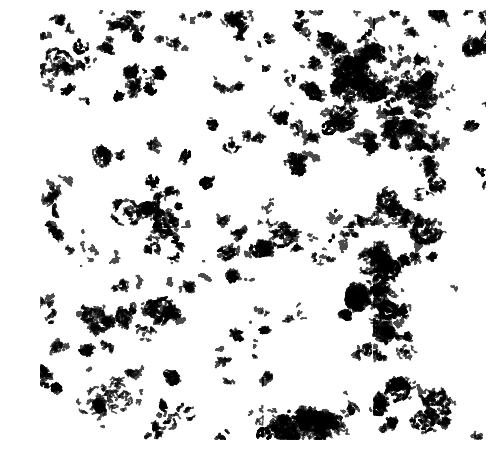

In [35]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

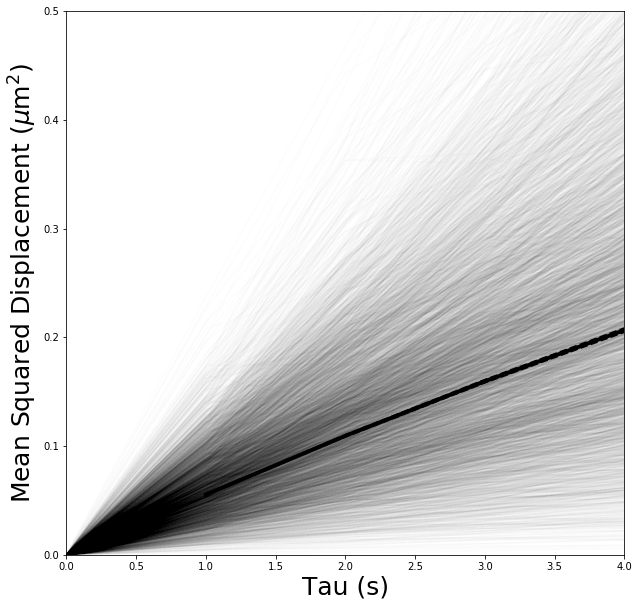

In [36]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [37]:
prefix = to_track[3]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted LPS_ipsi_PNN_vid_4 trajectories successfully.


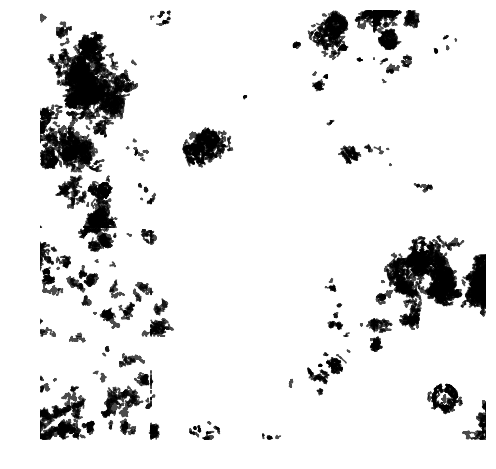

In [38]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

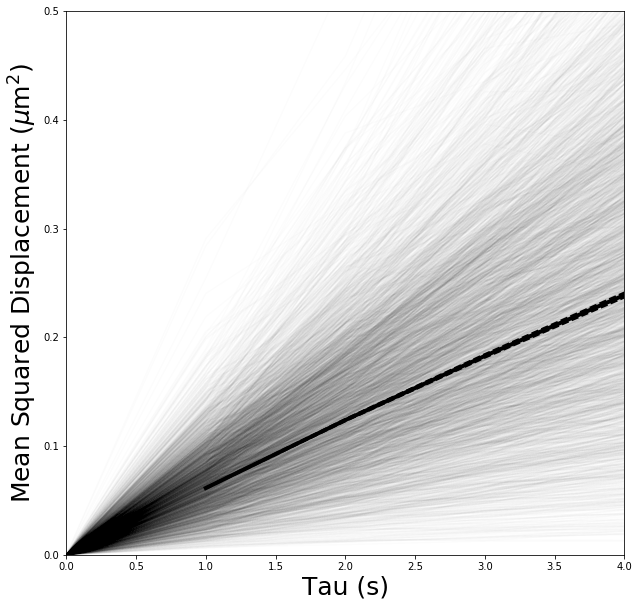

In [39]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [40]:
prefix = to_track[4]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted LPS_ipsi_PNN_vid_5 trajectories successfully.


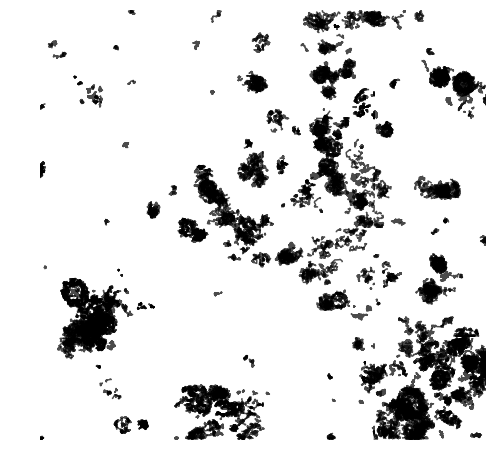

In [41]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

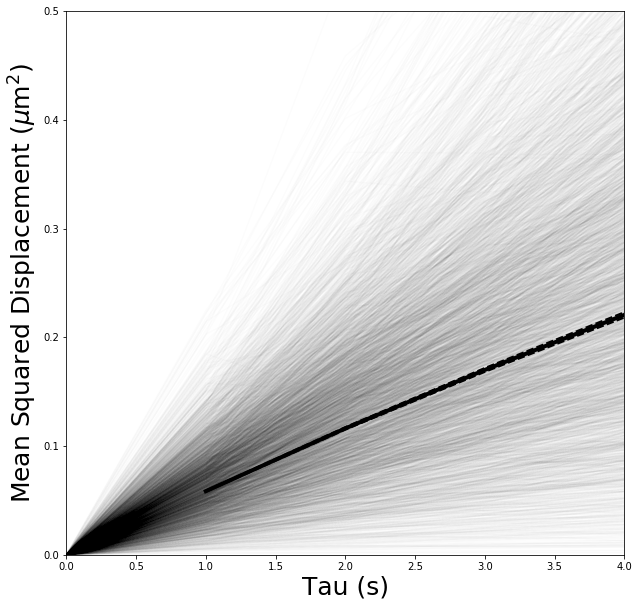

In [42]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [43]:
prefix = to_track[5]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted LPS_contra_PNN_vid_1 trajectories successfully.


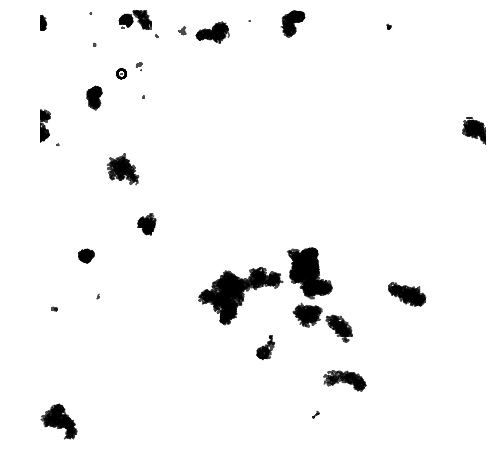

In [44]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

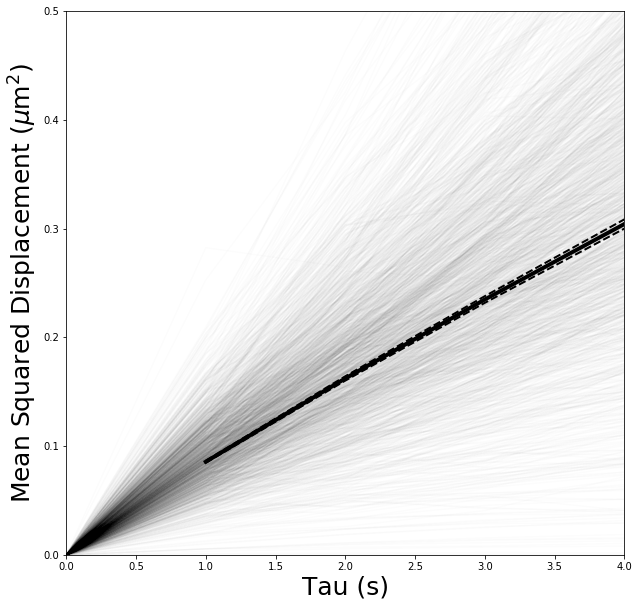

In [45]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [46]:
prefix = to_track[6]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted LPS_contra_PNN_vid_2 trajectories successfully.


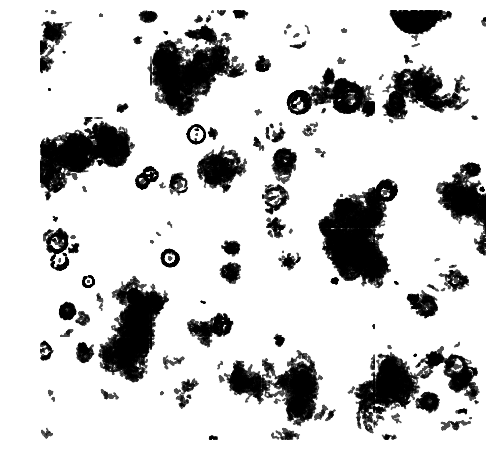

In [47]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

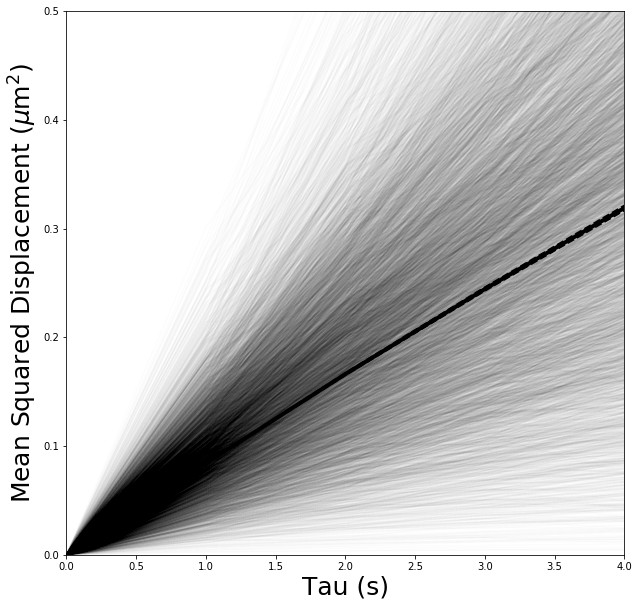

In [48]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [49]:
prefix = to_track[7]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted LPS_contra_PNN_vid_3 trajectories successfully.


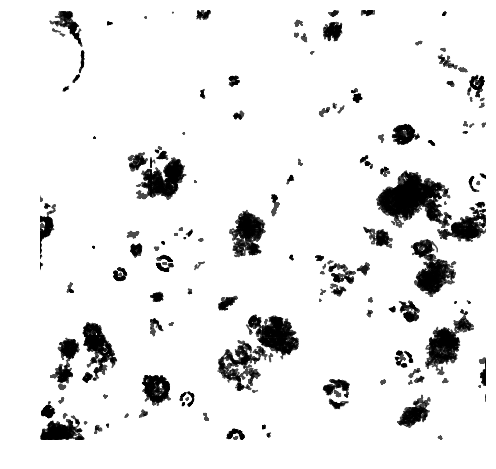

In [50]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

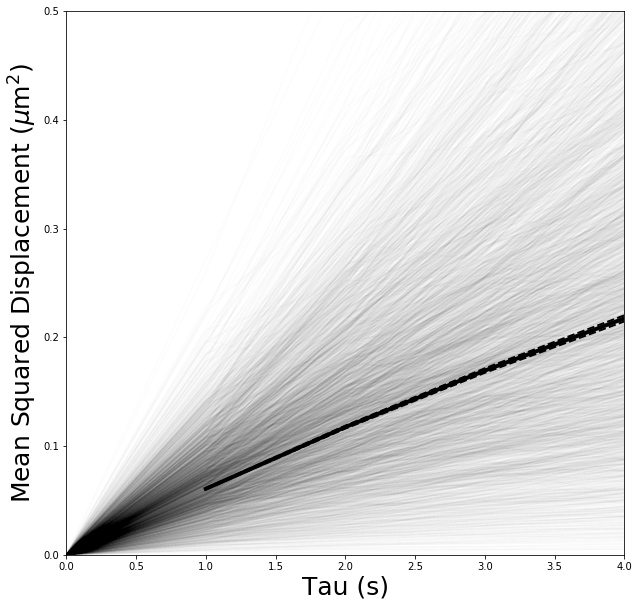

In [51]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [52]:
prefix = to_track[8]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted LPS_contra_PNN_vid_4 trajectories successfully.


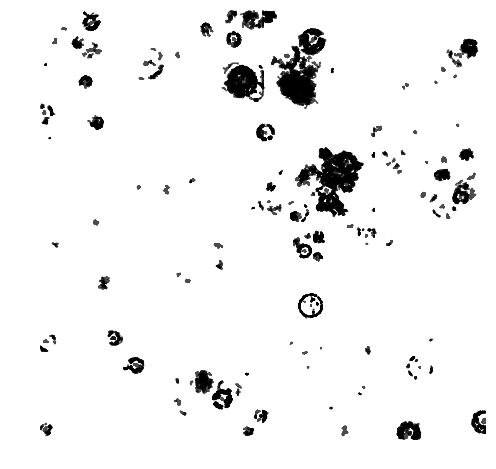

In [53]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

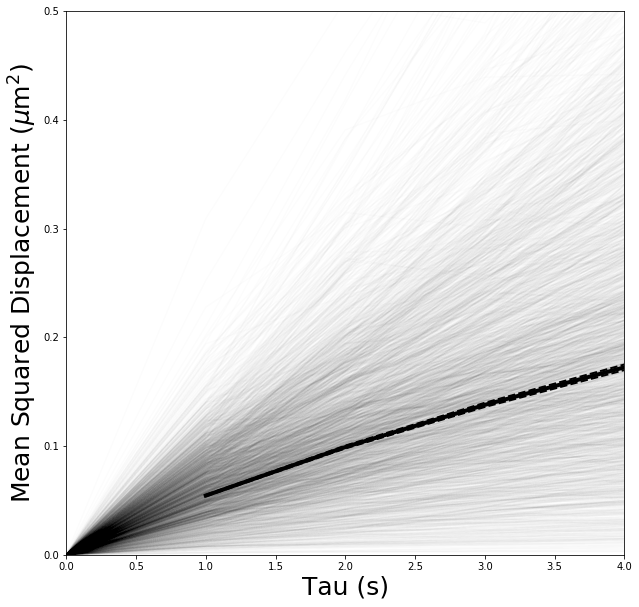

In [54]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [55]:
prefix = to_track[9]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted LPS_contra_PNN_vid_5 trajectories successfully.


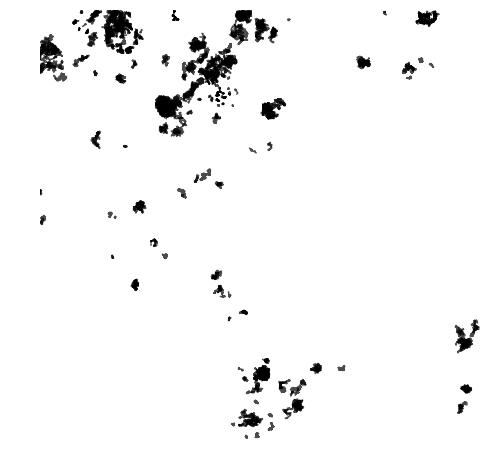

In [56]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

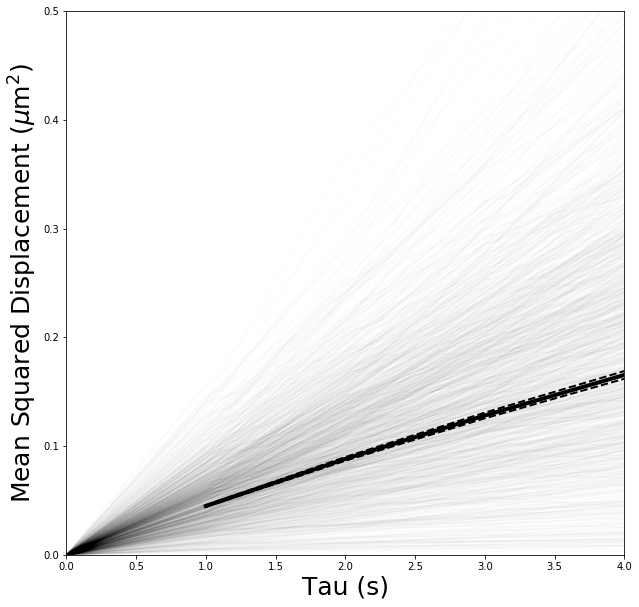

In [57]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [58]:
prefix = to_track[10]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted PAM_ipsi_vid_1 trajectories successfully.


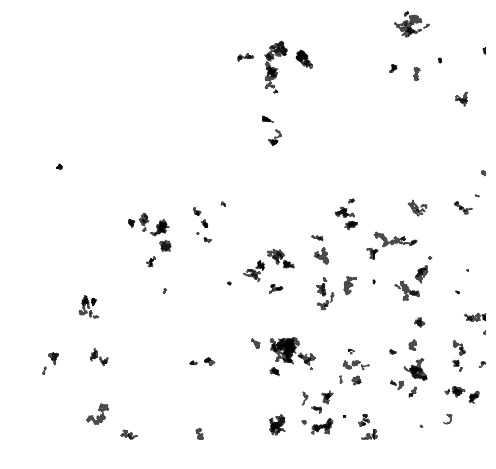

In [59]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

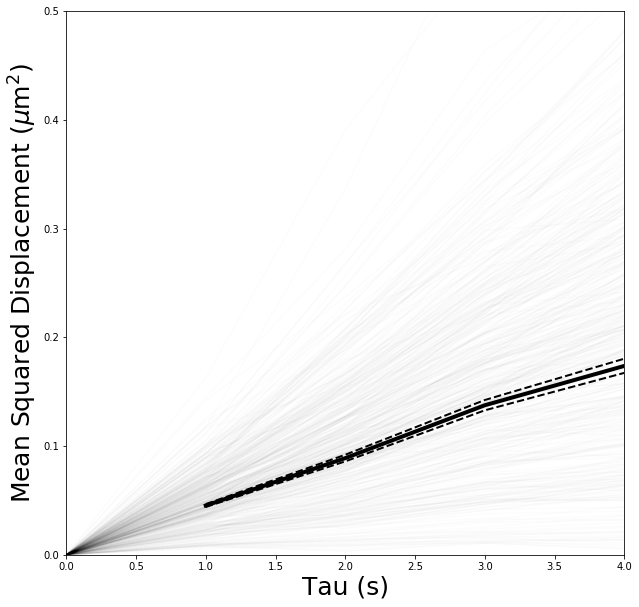

In [60]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [61]:
prefix = to_track[11]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted PAM_ipsi_vid_2 trajectories successfully.


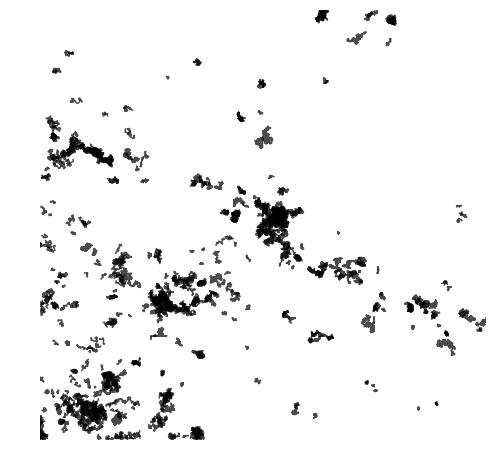

In [62]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

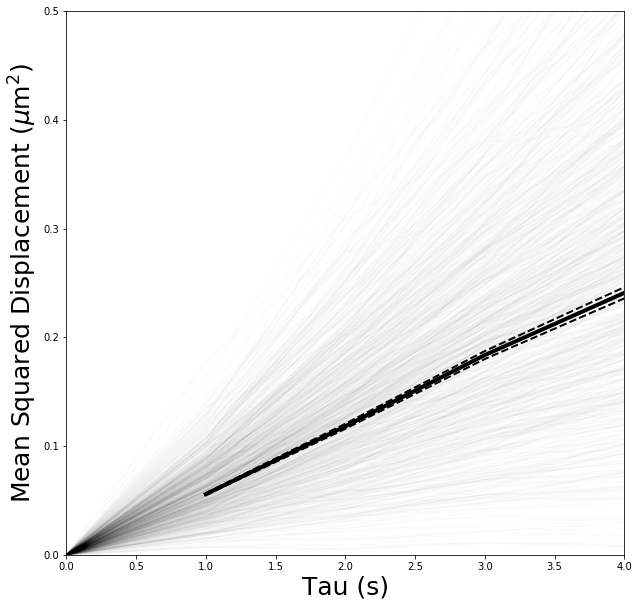

In [63]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [64]:
prefix = to_track[12]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted PAM_ipsi_vid_3 trajectories successfully.


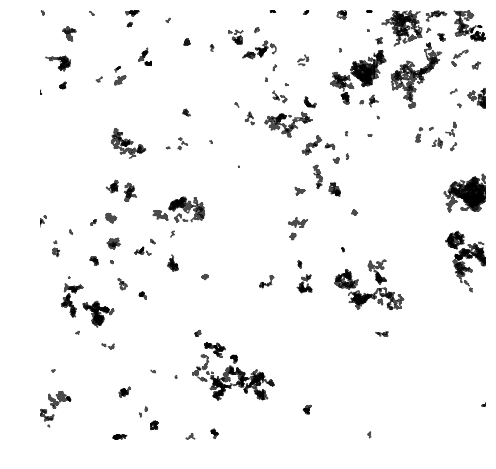

In [65]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

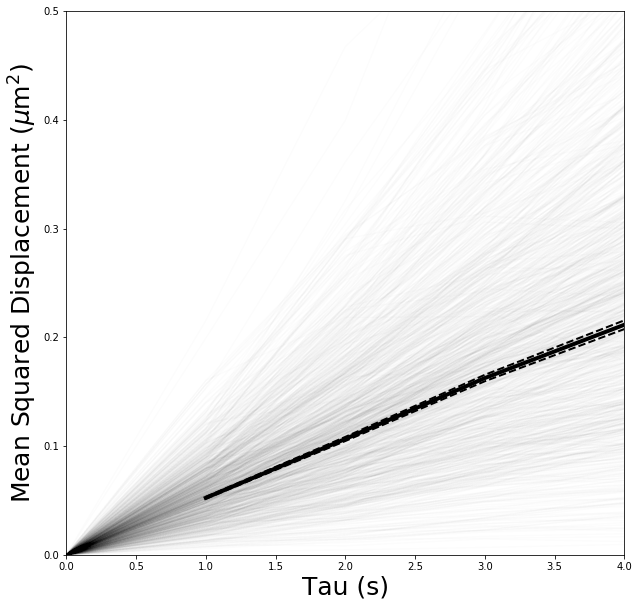

In [66]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [67]:
prefix = to_track[13]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted PAM_ipsi_vid_4 trajectories successfully.


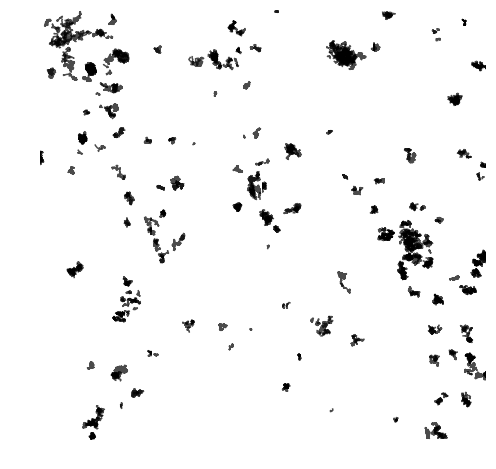

In [68]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

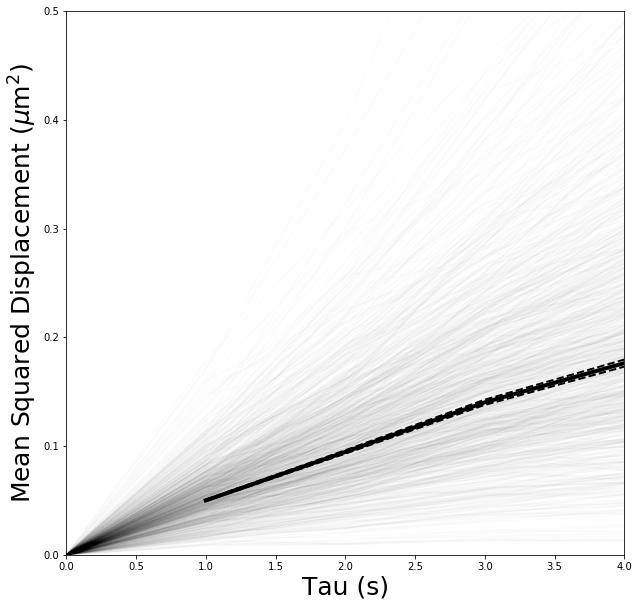

In [69]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [70]:
prefix = to_track[14]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted PAM_ipsi_vid_5 trajectories successfully.


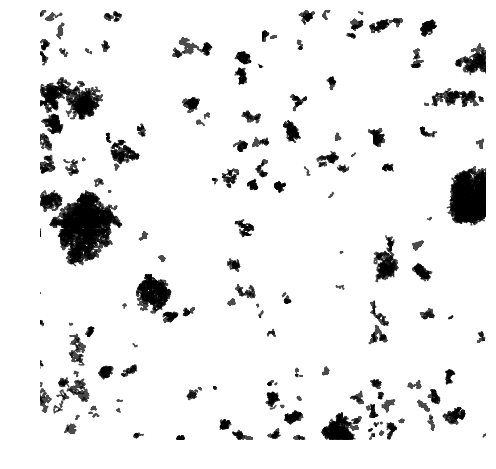

In [71]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

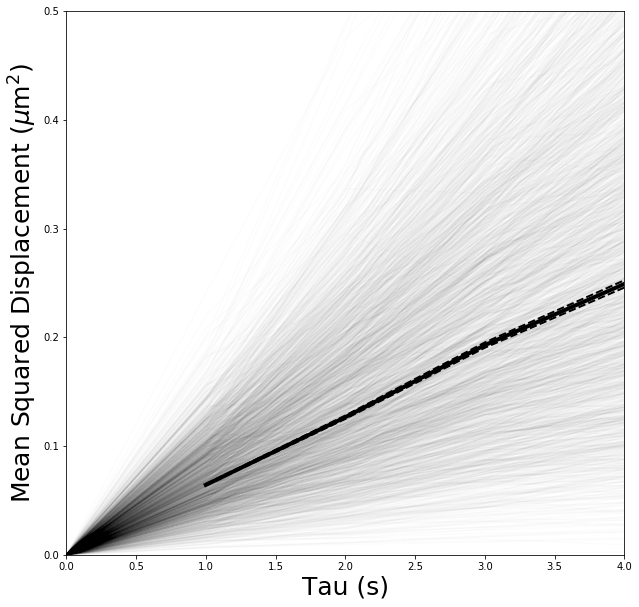

In [72]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [73]:
prefix = to_track[15]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted PAM_contra_vid_1 trajectories successfully.


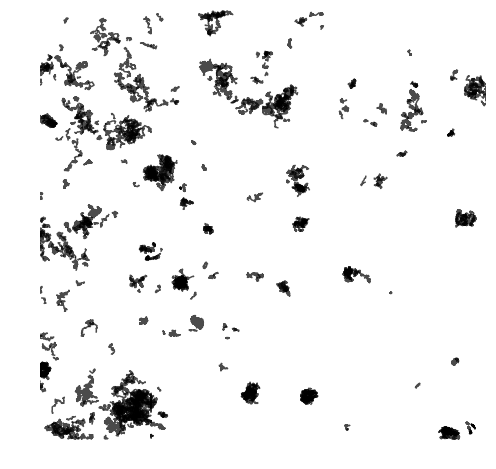

In [74]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

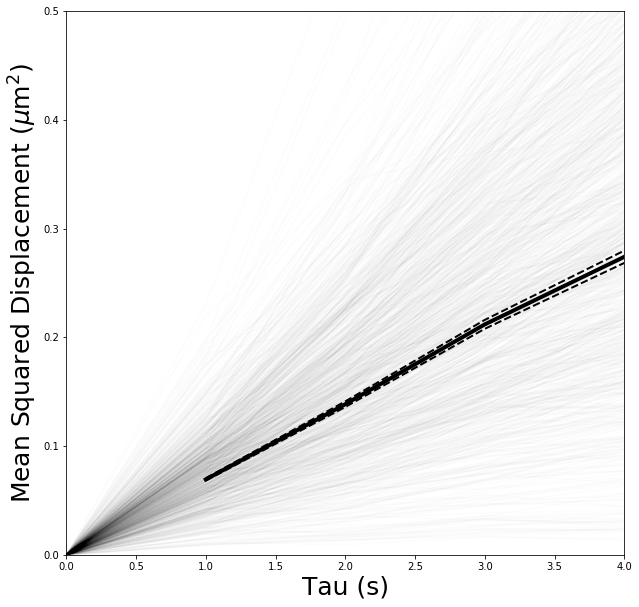

In [75]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [76]:
prefix = to_track[16]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted PAM_contra_vid_2 trajectories successfully.


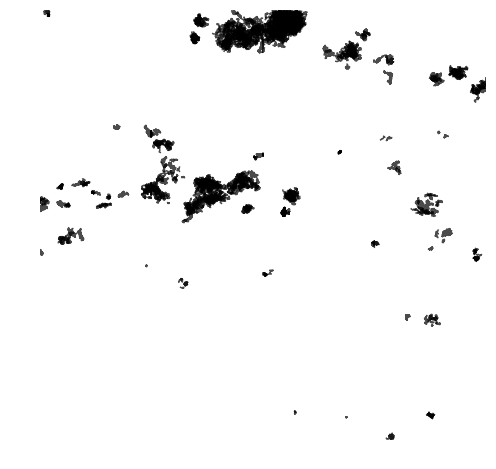

In [77]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

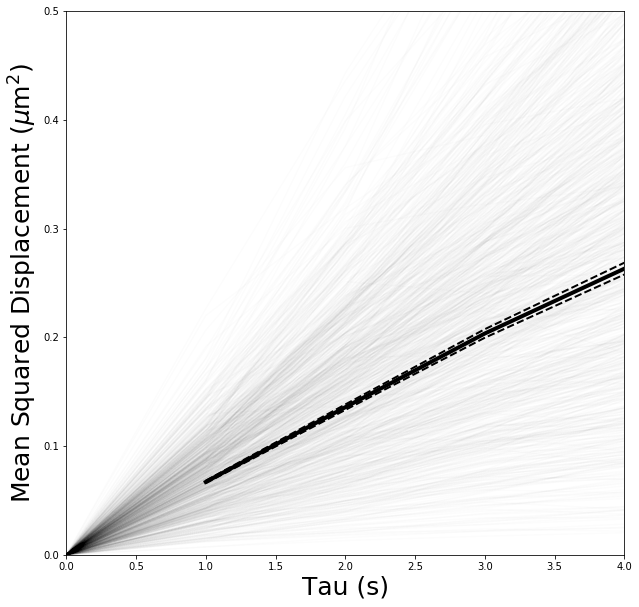

In [78]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [79]:
prefix = to_track[17]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted PAM_contra_vid_3 trajectories successfully.


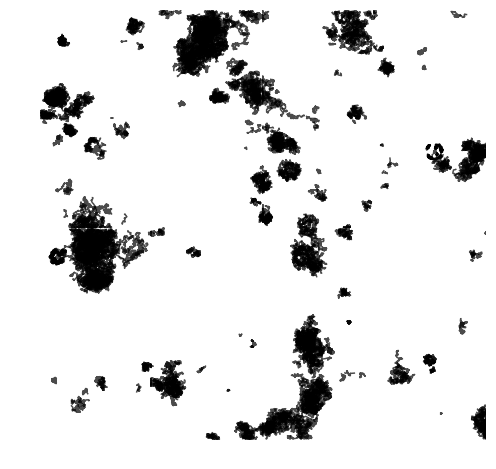

In [80]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

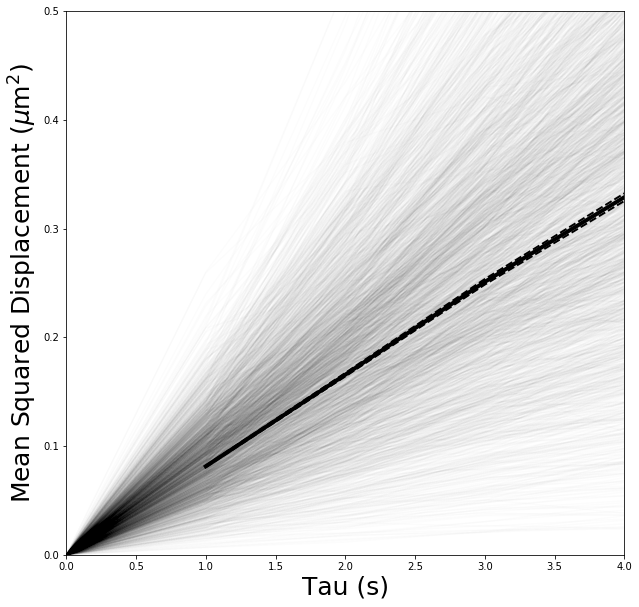

In [81]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [82]:
prefix = to_track[18]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted PAM_contra_vid_4 trajectories successfully.


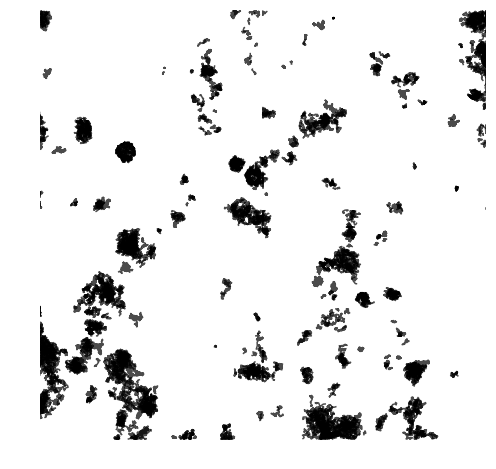

In [83]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

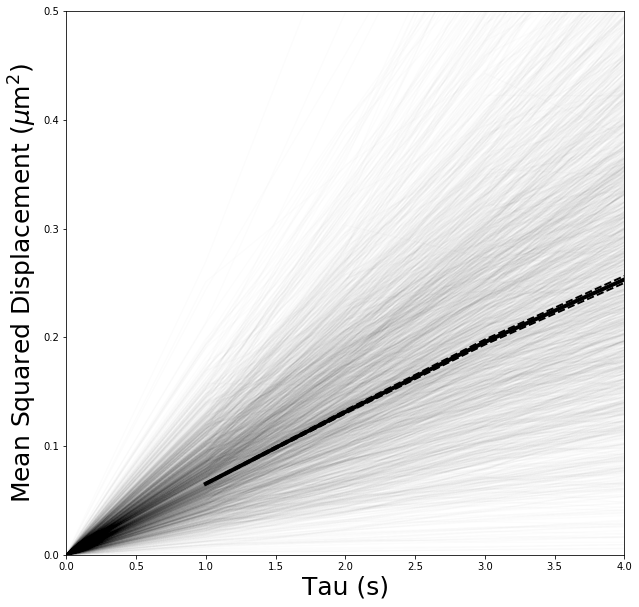

In [84]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [85]:
prefix = to_track[19]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

Plotted PAM_contra_vid_5 trajectories successfully.


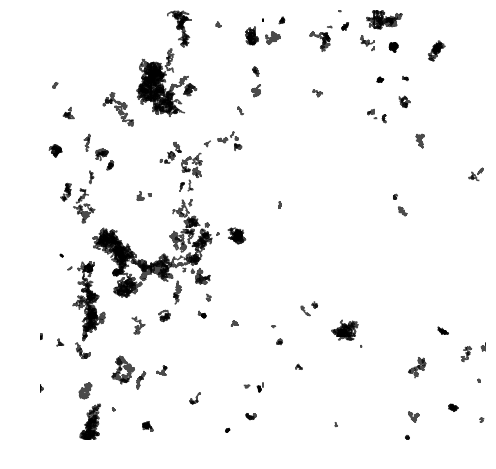

In [86]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

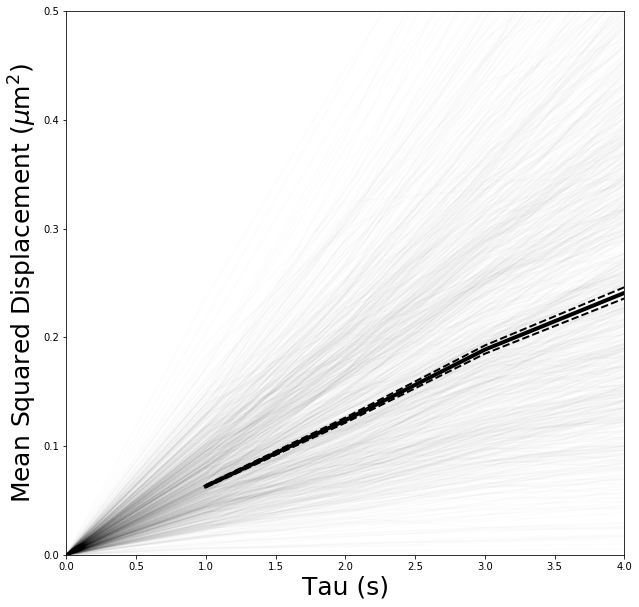

In [87]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=1, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [3]:
import pandas as pd
bucket = 'mckenna.data'
remote_folder = '11_16_18_MPT_in_PNNs'
prefix = 'HBSS_vid_3'
filename = "msd_{}.csv".format(prefix)
aws.download_s3(remote_folder+'/'+filename, filename, bucket_name=bucket)
local_name = filename
merged = pd.read_csv(local_name)

In [4]:
merged[391:400]

Unnamed: 0  Frame  Track_ID      X            Y  MSDs  Gauss    Quality  \
391         391  391.0       0.0  511.0  1138.000000   NaN    NaN  27.034317   
392         392  392.0       0.0  511.0  1140.000000   NaN    NaN  25.669601   
393         393  393.0       0.0  511.0  1144.000000   NaN    NaN  29.132843   
394         394  394.0       0.0  511.0  1145.000000   NaN    NaN  26.564743   
395         395  395.0       0.0  511.0  1145.166667   NaN    NaN  23.888158   
396         396  396.0       0.0  511.0  1145.333333   NaN    NaN  21.211573   
397         397  397.0       0.0  511.0  1145.500000   NaN    NaN  18.534988   
398         398  398.0       0.0  511.0  1145.666667   NaN    NaN  15.858404   
399         399  399.0       0.0  511.0  1145.833333   NaN    NaN  13.181819   

     SN_Ratio  Mean_Intensity  
391  1.539143      245.860465  
392  1.536820      235.767442  
393  1.283902      220.480620  
394  1.570980      235.782946  
395  1.524864      220.775194  
396  1.478747      205.767442  
397  1.432631      190.759690  
398  1.386515      175.751938  
399  1.340399      160.744186

In [5]:
print(merged['X'].dropna())

391       511.000000
392       511.000000
393       511.000000
394       511.000000
395       511.000000
396       511.000000
397       511.000000
398       511.000000
399       511.000000
400       511.000000
401       511.000000
402       511.000000
403       511.000000
404       511.000000
405       511.000000
406       511.000000
407       511.000000
408       511.000000
409       511.000000
410       511.000000
411       511.000000
412       511.000000
413       511.000000
414       511.000000
415       511.000000
416       511.000000
417       511.000000
418       511.000000
419       511.000000
420       511.000000
            ...     
19500    1920.702420
19501    1917.594596
19502    1914.756773
19503    1914.986936
19504    1918.752543
19505    1918.890704
19506    1917.182383
19507    1915.316349
19508    1914.483559
19509    1915.027157
19510    1910.413975
19511    1909.323364
19512    1909.146028
19513    1903.788259
19514    1904.255970
19515    1909.294802
19516    1906

In [6]:
merged['Euc'] = np.nan
merged[0:10]

Unnamed: 0  Frame  Track_ID   X   Y       MSDs     Gauss  Quality  \
0           0    0.0       0.0 NaN NaN   0.000000  0.000000      NaN   
1           1    1.0       0.0 NaN NaN   4.001641  2.396512      NaN   
2           2    2.0       0.0 NaN NaN   6.834146  1.681477      NaN   
3           3    3.0       0.0 NaN NaN   7.851303  1.606836      NaN   
4           4    4.0       0.0 NaN NaN   8.840694  1.439491      NaN   
5           5    5.0       0.0 NaN NaN  11.364362  1.123226      NaN   
6           6    6.0       0.0 NaN NaN  12.743154  1.025701      NaN   
7           7    7.0       0.0 NaN NaN  14.829385  0.891548      NaN   
8           8    8.0       0.0 NaN NaN  15.837694  0.879375      NaN   
9           9    9.0       0.0 NaN NaN  16.595764  0.835129      NaN   

   SN_Ratio  Mean_Intensity  Euc  
0       NaN             NaN  NaN  
1       NaN             NaN  NaN  
2       NaN             NaN  NaN  
3       NaN             NaN  NaN  
4       NaN             NaN  NaN  
5       NaN             NaN  NaN  
6       NaN             NaN  NaN  
7       NaN             NaN  NaN  
8       NaN             NaN  NaN  
9       NaN             NaN  NaN

In [7]:
import pandas as pd
bucket = 'mckenna.data'
remote_folder = '11_16_18_MPT_in_PNNs'
prefix = 'HBSS_vid_3'
filename = "features_{}.csv".format(prefix)
aws.download_s3(remote_folder+'/'+filename, filename, bucket_name=bucket)
feat_name = filename
feat_df = pd.read_csv(feat_name)

In [8]:
feat_df
feat_df['Euc'] = np.nan
feat_df[['Track_ID','D_fit','X','Y','frames','Deff1','Euc']][0:10]

Track_ID      D_fit            X            Y  frames     Deff1  Euc
0       0.0   1.234418   509.015730  1142.000000    37.0  0.408862  NaN
1       1.0  22.602545   506.762867  1151.349323   121.0  1.475014  NaN
2       2.0  22.318937   992.308138  1406.011083   651.0  1.542021  NaN
3       3.0   0.315534   534.741736  1124.659826   552.0  3.505944  NaN
4       4.0   4.453814   524.004213  1153.821478    95.0  1.853615  NaN
5       5.0   0.008623  1527.849205  1289.100075   651.0  0.000802  NaN
6       6.0   1.144086  1273.056117  1260.794551    44.0  1.090887  NaN
7       7.0   0.173863  1531.519726  1266.492676   651.0  0.028056  NaN
8       8.0  23.080683  1274.293518  1264.200154   496.0  1.749976  NaN
9       9.0   7.290224  1280.257552  1263.243048    51.0  1.385392  NaN